# Credit Risk Modelling: Data Modelling

In [2]:
import argparse

import numpy as np
import pandas as pd
from joblib import dump
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder


## Loading data

In [3]:
df = pd.read_csv("../../data/raw/dataset.csv", sep=";")
df.shape

(99976, 43)

# Train/Test split

In [4]:
df_train = df[~df.default.isnull()]
df_test = df[df.default.isnull()]

# Features

In [5]:
CATEGORICAL_FEATURES = [
    "merchant_category",
    "merchant_group",
    "name_in_email",
]
NUMERICAL_FEATURES = [
    "account_amount_added_12_24m",
    "account_days_in_dc_12_24m",
    "account_days_in_rem_12_24m",
    "account_days_in_term_12_24m",
    "account_incoming_debt_vs_paid_0_24m",
    "account_status",
    "account_worst_status_0_3m",
    "account_worst_status_12_24m",
    "account_worst_status_3_6m",
    "account_worst_status_6_12m",
    "age",
    "avg_payment_span_0_12m",
    "avg_payment_span_0_3m",
    "max_paid_inv_0_12m",
    "max_paid_inv_0_24m",
    "num_active_div_by_paid_inv_0_12m",
    "num_active_inv",
    "num_arch_dc_0_12m",
    "num_arch_dc_12_24m",
    "num_arch_ok_0_12m",
    "num_arch_ok_12_24m",
    "num_arch_rem_0_12m",
    "num_unpaid_bills",
    "status_last_archived_0_24m",
    "status_2nd_last_archived_0_24m",
    "status_3rd_last_archived_0_24m",
    "status_max_archived_0_6_months",
    "status_max_archived_0_12_months",
    "status_max_archived_0_24_months",
    "recovery_debt",
    "sum_capital_paid_account_0_12m",
    "sum_capital_paid_account_12_24m",
    "sum_paid_inv_0_12m",
    "time_hours",
    "worst_status_active_inv",
]
# Features which won't be used during the training
OTHER_FEATURES = [
    "has_paid",
    "num_arch_written_off_0_12m",
    "num_arch_written_off_12_24m",
    "uuid",
    "default",
]
MODEL_FEATURES = CATEGORICAL_FEATURES + NUMERICAL_FEATURES
VALID_FEATURES = MODEL_FEATURES + OTHER_FEATURES

# Sanity check: making sure that the same feature doesn't appear multiple times in the list
assert len(set(VALID_FEATURES)) == len(VALID_FEATURES)


# Model

In [6]:
model = Pipeline([
    ("feature_preprocessor", ColumnTransformer([
        # Note: Oridnal encoding works quite well for the models based on decision trees
        ("categorical", OrdinalEncoder(handle_missing="return_nan"), CATEGORICAL_FEATURES),
        # Numerical features will be passed through the model without any changes
        ("numerical", "passthrough", NUMERICAL_FEATURES)
    ])),
    ("classifier", lightgbm.LGBMClassifier(
        n_estimators=400,
        num_leaves=12,
        max_depth=4,
        learning_rate=0.02,
        colsample_bytree=0.5,
    )),
])

# Cross validataion

In [7]:
def run_cross_validation(df_train):
    kfold = KFold(n_splits=10)

    X = df_train
    y = df_train.default

    results = []

    for index, (train_index, test_index) in enumerate(kfold.split(X), start=1):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        probas = model.predict_proba(X_val)
        positive_label_proba = probas[:, 1]

        auc_score = roc_auc_score(y_val, positive_label_proba)
        print(f"[Fold #{index}] ROC AUC Score: {auc_score:.3f}")
        results.append(auc_score)

    print(f"ROC AUC Score: {np.mean(results):.3f} (+/-{2 * np.std(results):.3f})")

In [8]:
run_cross_validation(df_train)

[Fold #1] ROC AUC Score: 0.928
[Fold #2] ROC AUC Score: 0.901
[Fold #3] ROC AUC Score: 0.919
[Fold #4] ROC AUC Score: 0.915
[Fold #5] ROC AUC Score: 0.890
[Fold #6] ROC AUC Score: 0.891
[Fold #7] ROC AUC Score: 0.924
[Fold #8] ROC AUC Score: 0.919
[Fold #9] ROC AUC Score: 0.926
[Fold #10] ROC AUC Score: 0.906
ROC AUC Score: 0.912 (+/-0.027)


# Production Model: Training

In [9]:
model.fit(df_train, df_train.default)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_missing='return_nan'),
                                                  ['merchant_category',
                                                   'merchant_group',
                                                   'name_in_email']),
                                                 ('numerical', 'passthrough',
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'account_incoming_...
                                                   'num_unpaid_bills',
                                                   'status_last_archived_0_24m',
                                                   'status_2nd_last_archived_0_24m',
                                                   'status_3rd_last_archived_0_24m',
                                                   'status_max_archived_0_6_months',
                                                   'status_max_archived_0_12_months',
                                                   'status_max_archived_0_24_months',
                                                   'recovery_debt', ...])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5, learning_rate=0.02,
                                max_depth=4, n_estimators=400,
                                num_leaves=12))])

# Predictions

In [10]:
probas = model.predict_proba(df_test)
df_test_results = pd.DataFrame({"uuid": df_test.uuid, "pd": probas[:, 1]})
df_test_results.head()

,uuid,pd
89976,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.004082
89977,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.006012
89978,e9c39869-1bc5-4375-b627-a2df70b445ea,0.005374
89979,6beb88a3-9641-4381-beb6-c9a208664dd0,0.013611
89980,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.043962


# Visualisation

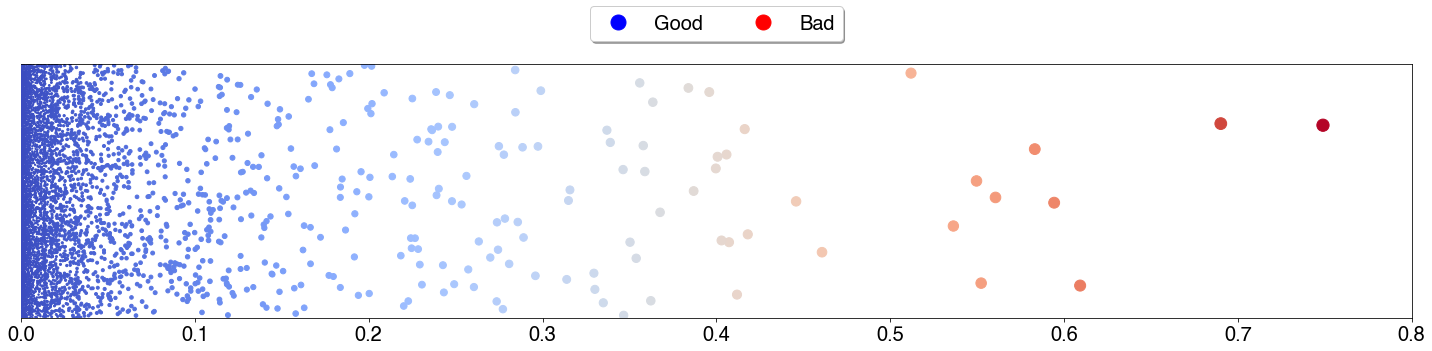

In [78]:
import matplotlib as mpl
mpl.rcParams['font.family'] = ['Helvetica']

y = np.random.random(10000)

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(-1,-1, color='blue', marker='o', ms=15, ls='None', label='Good')
ax.plot(-1,-1, color='red', marker='o', ms=15, ls='None', label='Bad')

ax.scatter(df_test_results.pd, y, c=df_test_results.pd, s=200*df_test_results.pd, cmap='coolwarm')
ax.set_xlim([0,0.8])
ax.set_ylim([0,1])


ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=20)

ax.set_yticks([])
ax.spines[['left']].set_visible(False)
ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('./cover_pic_creditrisk.png')